In [1]:
import os
import config
import platform
v1, v2, v3 = config.spark_env(platform.node())
os.environ['SPARK_VERSION'] = v1
os.environ['JAVA_HOME'] = v2
os.environ['SPARK_HOME'] = v3
import findspark
import pyspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.appName("emissionsdataframe").getOrCreate()
from sqlalchemy import create_engine, insert
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import MetaData, update, Table
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.functions import array, col, explode, lit, struct, log
from pyspark.sql import DataFrame
from typing import Iterable
import numpy as np
import spark_functions
import tensorflow as tf
import keras.metrics
import pyspark.sql.functions as F
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pystan
import fbprophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import scipy.stats as st
from pyspark.sql import Row
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import MetaData, Table

rds_string = config.rds_string
engine = create_engine(f'postgresql://{rds_string}')
conn = engine.connect()
metadata = MetaData(engine)

In [2]:
def melt(
        df: DataFrame, 
        id_vars: Iterable[str], value_vars: Iterable[str], 
        var_name: str="variable", value_name: str="value") -> DataFrame:
    """Convert :class:`DataFrame` from wide to long format."""

    # Create array<struct<variable: str, value: ...>>
    _vars_and_vals = array(*(
        struct(lit(c).alias(var_name), col(c).alias(value_name)) 
        for c in value_vars))

    # Add to the DataFrame and explode
    _tmp = df.withColumn("_vars_and_vals", explode(_vars_and_vals))

    cols = id_vars + [
            col("_vars_and_vals")[x].alias(x) for x in [var_name, value_name]]
    return _tmp.select(*cols)


def min_int(df,column):
    arr = np.array(df.select(column).collect())
    y_l = []
    for i in arr:
        y_l.append(int(i[0]))
    min_ = min(y_l)
    max_ = max(y_l)
    return (min_, max_)  


def sql_to_spark_gdp(country):
    table_var = Table("gdp_data", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    query = session.query(table_var).filter(table_var.c.Country == country).all()
    steve = table_var.metadata.tables["gdp_data"].columns.keys()
    query_list = []
    for i in query:
        q_len = len(i)
        temp_dict = {}
        for j in range(q_len):
            key = steve[j]
            value = i[j]
            if value == None:
                value = float(0)
            temp_dict[key] = value
            if j == (q_len - 1):
                query_list.append(temp_dict)
    df = spark.createDataFrame(Row(**x) for x in query_list)
    gdp_col = df.columns
    gdp_col2 = gdp_col[2:]
    gdp_static_cols = gdp_col[:2]
    df = melt(df, id_vars=gdp_static_cols, value_vars=gdp_col2)
    df = df.withColumn("variable",df.variable.cast('int'))
    df = df.withColumnRenamed("variable","year")
    df = df.withColumnRenamed("value","gdp")
    df = df.withColumnRenamed("Country","country")
    df = df.select(['country','year','gdp'])
    return df

def sql_to_spark_emissions(country):
    table_var = Table("global_emissions", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    query = session.query(table_var).filter(table_var.c.Entity == country).all()
    steve = table_var.metadata.tables["global_emissions"].columns.keys()
    query_list = []
    for i in query:
        q_len = len(i)
        temp_dict = {}
        for j in range(q_len):
            key = steve[j]
            value = i[j]
            if value == None:
                value = float(0)
            temp_dict[key] = value
            if j == (q_len - 1):
                query_list.append(temp_dict)
    df = spark.createDataFrame(Row(**x) for x in query_list)
    df = df.withColumnRenamed("Entity","country")
    df = df.withColumnRenamed("Year","year")
    return df

def sql_to_spark_trade(country):
    table_var = Table("global_trade", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    query = session.query(table_var).filter(table_var.c.country_or_area == country).all()
    steve = table_var.metadata.tables["global_trade"].columns.keys()
    c_list = []
    for i in query:
        q_len = len(i)
        if i[0] == country:
            temp_dict = {}
            for j in range(q_len):
                key = steve[j]
                value = i[j]
                if value == None:
                    value = float(0)
                temp_dict[key] = value
                if j == (q_len - 1):
                    c_list.append(temp_dict)
    df = spark.createDataFrame(Row(**x) for x in c_list)
    df = df.withColumn("year",df.year.cast('int'))
    df = df.withColumnRenamed("country_or_area","country")
    df_export = df.filter(df['flow'] == "Export")
    df_import = df.filter(df['flow'] == "Import")
    return (df_export, df_import)




def merged_df(country):
    if country == "United States":
        export_df, import_df = sql_to_spark_trade("USA")
    else:
        export_df, import_df = sql_to_spark_trade(country)
    export_df_min, export_df_max = min_int(export_df, 'year')
    import_df_min, import_df_max = min_int(import_df, 'year')

    gdp_spark = sql_to_spark_gdp(country)
    gdp_spark_min, gdp_spark_max = min_int(gdp_spark, "year")

    emissions_spark = sql_to_spark_emissions(country)
    emissions_min, emissions_max = min_int(emissions_spark, 'year')

    years_df = pd.DataFrame([{"min":export_df_min, "max":export_df_max},
    {"min":import_df_min, "max":import_df_max},
    {"min":gdp_spark_min, "max":gdp_spark_max},
    {"min":emissions_min, "max":emissions_max}])

    lower_bound = years_df['min'].max()
    upper_bound = years_df['max'].min()

    gdp_spark = gdp_spark.filter(gdp_spark["year"] >= lower_bound)
    gdp_spark = gdp_spark.filter(gdp_spark["year"] <= upper_bound)
    emissions_spark = emissions_spark.filter(emissions_spark["year"] >= lower_bound)
    emissions_spark = emissions_spark.filter(emissions_spark["year"] <= upper_bound)
    import_df = import_df.filter(import_df["year"] >= lower_bound)
    import_df = import_df.filter(import_df["year"] <= upper_bound)
    export_df = export_df.filter(export_df["year"] >= lower_bound)
    export_df = export_df.filter(export_df["year"] <= upper_bound)
    merged_df = gdp_spark.join(emissions_spark, gdp_spark.year == emissions_spark.year, 'outer') \
    .select(gdp_spark.country ,gdp_spark.year,gdp_spark.gdp, emissions_spark.annual_co2_emissions_tonnes) \
    .distinct()
    merged_df = merged_df.orderBy(merged_df.year.asc())
    import_sum = import_df.groupBy('year').sum()
    import_sum = import_sum.orderBy(import_sum.year.asc())
    import_sum = import_sum.withColumnRenamed("sum(trade_usd)","import_trade_sum_usd")
    import_sum = import_sum.withColumnRenamed("sum(weight_kg)","import_weight_sum_kg")
    import_sum = import_sum.withColumnRenamed("sum(quantity)","import_quantity_sum")
    export_sum = export_df.groupBy('year').sum()
    export_sum = export_sum.orderBy(export_sum.year.asc())
    export_sum = export_sum.withColumnRenamed("sum(trade_usd)","export_trade_sum_usd")
    export_sum = export_sum.withColumnRenamed("sum(weight_kg)","export_weight_sum_kg")
    export_sum = export_sum.withColumnRenamed("sum(quantity)","export_quantity_sum")
    merged_df = merged_df.join(import_sum, merged_df.year == import_sum.year, 'outer') \
    .select(merged_df.country ,merged_df.year,merged_df.gdp, merged_df.annual_co2_emissions_tonnes,
        import_sum['import_trade_sum_usd'],import_sum['import_weight_sum_kg'],import_sum['import_quantity_sum']) \
    .distinct()
    merged_df = merged_df.orderBy(merged_df.year.asc())
    merged_df = merged_df.join(export_sum, merged_df.year == export_sum.year, 'outer') \
    .select(merged_df.country ,merged_df.year,merged_df.gdp, merged_df.annual_co2_emissions_tonnes,
        merged_df['import_trade_sum_usd'],merged_df['import_weight_sum_kg'],merged_df['import_quantity_sum'],
        export_sum['export_trade_sum_usd'],export_sum['export_weight_sum_kg'],export_sum['export_quantity_sum']
        ) \
    .distinct()
    merged_df = merged_df.orderBy(merged_df.year.asc())
    merged_df = merged_df.withColumn("annual_co2_emissions_tonnes_log", F.log10(col("annual_co2_emissions_tonnes")))
    merged_df = merged_df.withColumn("import_trade_sum_usd_log", F.log10(col("import_trade_sum_usd")))
    merged_df = merged_df.withColumn("import_weight_sum_kg_log", F.log10(col("import_weight_sum_kg")))
    merged_df = merged_df.withColumn("import_quantity_sum_log", F.log10(col("import_quantity_sum")))
    merged_df = merged_df.withColumn("export_trade_sum_usd_log", F.log10(col("export_trade_sum_usd")))
    merged_df = merged_df.withColumn("export_weight_sum_kg_log", F.log10(col("export_weight_sum_kg")))
    merged_df = merged_df.withColumn("export_quantity_sum_log", F.log10(col("export_quantity_sum")))
    merged_df = merged_df.select('country',
                    'year',
                    'gdp',
                    'annual_co2_emissions_tonnes_log',
                    'import_trade_sum_usd_log',
                    'import_weight_sum_kg_log',
                    'import_quantity_sum_log',
                    'export_trade_sum_usd_log',
                    'export_weight_sum_kg_log',
                    'export_quantity_sum_log')


    columns = merged_df.columns
   
    return (merged_df, columns)

def check_list():
    table_var = Table("gdp_data", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    q = session.query(table_var).distinct(table_var.c.Country).all()
    checker = []
    for row in q:
        checker.append(row[0])
    return checker

    
checker = check_list()
checker


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Arab World',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Caribbean small states',
 'Cayman Islands',
 'Central African Republic',
 'Central Europe and the Baltics',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'East Asia & Pacific (IDA & IBRD countries)',
 'East Asia & Pacific (excluding high income)',
 'E

In [3]:
def country_list():
    holder = False
    countries = []
    while holder == False:
        country = input(f'What country would you like to add? ')
        try:
            if country in checker:
                if country not in countries:
                    countries.append(country)
        except:
            print("not a valid country")
        switch = input(f'Would you like to add another? y/n ') 
        if switch == 'n':
            holder = True
    return countries
countries = country_list()

What country would you like to add? China
Would you like to add another? y/n y
What country would you like to add? France
Would you like to add another? y/n Spain
What country would you like to add? Spain
Would you like to add another? y/n y
What country would you like to add? India
Would you like to add another? y/n y
What country would you like to add? United States
Would you like to add another? y/n y
What country would you like to add? Canada
Would you like to add another? y/n y
What country would you like to add? Argentina
Would you like to add another? y/n y
What country would you like to add? Japan
Would you like to add another? y/n n


In [4]:
def df_maker(arr):
    c_dict = {}
    for i in arr:
        temp_dict = {}
        df, cols = merged_df(i)
        c_dict[i] = {'df': df}
        c_dict['cols'] = cols
    steve = len(arr)    
    df = c_dict[arr[0]]['df']
    for i in range(steve - 1):
        column = arr[i+1]
        df2 = c_dict[column]['df']
        df = df.union(df2)
    c_dict['union'] = {'df':df}
    return c_dict

diction = df_maker(countries)

def make_models(diction):
    col_len = len(diction['cols'][2:])
    dict_ = {}
    for i in range(col_len):
        tempz_dict = {}
        temp_dict = {}
        colz = diction['cols'][2:]
        y = colz[i]
        colz.remove(colz[i])
        x = colz

        arr = np.array(diction['union']['df'].select(
         x[0],
         x[1],
         x[2],
         x[3],
         x[4],
         x[5],
         x[6]) \
        .collect(),dtype = 'float')    
        arr2 = np.array(diction['union']['df'].select(y).collect(),dtype = 'float')
        tempz_dict = {'x':arr,'y':arr2}
        X_train, X_test, y_train, y_test = train_test_split(arr, arr2, test_size=0.2)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)
        tempz_dict['train'] = [X_train,y_train]
        tempz_dict['test'] = [X_test,y_test]
        tempz_dict['val'] = [X_val,y_val]
        X_scaler = StandardScaler().fit(X_train)
        tempz_dict['scaler'] = X_scaler
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        X_val_scaled = X_scaler.transform(X_val)
        model = Sequential()
        model.add(Dense(units=100, activation='relu', input_dim=7))
        model.add(Dense(units=100, activation='relu'))
        model.add(Dense(units=100, activation='ReLU'))
        model.add(Dense(units=100, activation='PReLU'))
        model.add(Dense(units=100, activation='swish'))
        model.add(Dense(units=1, activation='linear'))
        METRICS = [
              keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
              keras.metrics.MeanSquaredError(name='mean_squared_error')
        ]


        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='mse', 
            verbose=1,
            patience=10,
            mode='max',
            restore_best_weights=True)

        EPOCHS = 100    
        model.compile(optimizer='adam',
                  loss='mse',
                  metrics=METRICS)

        model_history = model.fit(
        X_train_scaled,
        y_train,
        epochs=EPOCHS,
        validation_data=(X_test_scaled, y_test)
        )
        tempz_dict['model'] = model
        diction[y] = tempz_dict
    return diction

diction = make_models(diction)

def spark_to_prophet(df, column):
    arr = np.array(df.collect())
    df = pd.DataFrame(arr, columns = column)
    ds_len = len(df)
    dates = []
    for i in range(ds_len):
        year = str(int(df['year'][i]))
        year = year + "-01-01"
        dates.append(year)
    df['year'] = dates
    return df
def make_prophet_model(df,periods):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=periods, freq='Y')
    forecast = m.predict(future)
    return (forecast, m)



ERROR:sqlalchemy.pool.impl.QueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\popes\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\popes\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\popes\anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



Epoch 1/100
6/6 [==============================] - 1s 30ms/step - loss: 752335488.0000 - mean_absolute_error: 23394.8320 - mean_squared_error: 752335488.0000 - val_loss: 718376576.0000 - val_mean_absolute_error: 21949.5312 - val_mean_squared_error: 718376576.0000
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 752299456.0000 - mean_absolute_error: 23394.0098 - mean_squared_error: 752299456.0000 - val_loss: 718314240.0000 - val_mean_absolute_error: 21948.2031 - val_mean_squared_error: 718314240.0000
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 752205312.0000 - mean_absolute_error: 23391.9805 - mean_squared_error: 752205312.0000 - val_loss: 718156352.0000 - val_mean_absolute_error: 21944.8477 - val_mean_squared_error: 718156352.0000
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 751974464.0000 - mean_absolute_error: 23386.9199 - mean_squared_error: 751974464.0000 - val_loss: 717756864.0000 - val_mean_absolute_error:

6/6 [==============================] - 0s 7ms/step - loss: 41549732.0000 - mean_absolute_error: 4847.7505 - mean_squared_error: 41549732.0000 - val_loss: 18120360.0000 - val_mean_absolute_error: 3333.4873 - val_mean_squared_error: 18120360.0000
Epoch 33/100
6/6 [==============================] - 0s 7ms/step - loss: 38999708.0000 - mean_absolute_error: 4693.1147 - mean_squared_error: 38999708.0000 - val_loss: 16239704.0000 - val_mean_absolute_error: 3117.0730 - val_mean_squared_error: 16239704.0000
Epoch 34/100
6/6 [==============================] - 0s 7ms/step - loss: 35402064.0000 - mean_absolute_error: 4366.7866 - mean_squared_error: 35402064.0000 - val_loss: 11920971.0000 - val_mean_absolute_error: 2594.4526 - val_mean_squared_error: 11920971.0000
Epoch 35/100
6/6 [==============================] - 0s 7ms/step - loss: 32569922.0000 - mean_absolute_error: 4230.3789 - mean_squared_error: 32569922.0000 - val_loss: 10667466.0000 - val_mean_absolute_error: 2468.1465 - val_mean_squared_er

6/6 [==============================] - 0s 7ms/step - loss: 14929619.0000 - mean_absolute_error: 2827.1162 - mean_squared_error: 14929619.0000 - val_loss: 7483614.5000 - val_mean_absolute_error: 2128.3281 - val_mean_squared_error: 7483614.5000
Epoch 65/100
6/6 [==============================] - 0s 7ms/step - loss: 14864866.0000 - mean_absolute_error: 2785.9709 - mean_squared_error: 14864866.0000 - val_loss: 7882118.0000 - val_mean_absolute_error: 2237.1331 - val_mean_squared_error: 7882118.0000
Epoch 66/100
6/6 [==============================] - 0s 7ms/step - loss: 14832506.0000 - mean_absolute_error: 2760.1440 - mean_squared_error: 14832506.0000 - val_loss: 7326002.0000 - val_mean_absolute_error: 2171.2705 - val_mean_squared_error: 7326002.0000
Epoch 67/100
6/6 [==============================] - 0s 7ms/step - loss: 14467665.0000 - mean_absolute_error: 2728.4231 - mean_squared_error: 14467665.0000 - val_loss: 6877018.0000 - val_mean_absolute_error: 2104.9409 - val_mean_squared_error: 68

6/6 [==============================] - 0s 7ms/step - loss: 11033328.0000 - mean_absolute_error: 2302.6245 - mean_squared_error: 11033328.0000 - val_loss: 6002505.5000 - val_mean_absolute_error: 1967.4352 - val_mean_squared_error: 6002505.5000
Epoch 97/100
6/6 [==============================] - 0s 7ms/step - loss: 11095963.0000 - mean_absolute_error: 2249.5017 - mean_squared_error: 11095963.0000 - val_loss: 5224687.0000 - val_mean_absolute_error: 1859.9580 - val_mean_squared_error: 5224687.0000
Epoch 98/100
6/6 [==============================] - 0s 7ms/step - loss: 10598902.0000 - mean_absolute_error: 2275.5066 - mean_squared_error: 10598902.0000 - val_loss: 5193198.5000 - val_mean_absolute_error: 1842.6553 - val_mean_squared_error: 5193198.5000
Epoch 99/100
6/6 [==============================] - 0s 7ms/step - loss: 10828404.0000 - mean_absolute_error: 2339.3198 - mean_squared_error: 10828404.0000 - val_loss: 5155840.5000 - val_mean_absolute_error: 1797.0896 - val_mean_squared_error: 51

Epoch 32/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2051 - mean_absolute_error: 0.3008 - mean_squared_error: 0.2051 - val_loss: 0.1761 - val_mean_absolute_error: 0.3178 - val_mean_squared_error: 0.1761
Epoch 33/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1853 - mean_absolute_error: 0.2907 - mean_squared_error: 0.1853 - val_loss: 0.1754 - val_mean_absolute_error: 0.3102 - val_mean_squared_error: 0.1754
Epoch 34/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1622 - mean_absolute_error: 0.2704 - mean_squared_error: 0.1622 - val_loss: 0.1882 - val_mean_absolute_error: 0.3172 - val_mean_squared_error: 0.1882
Epoch 35/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1498 - mean_absolute_error: 0.2652 - mean_squared_error: 0.1498 - val_loss: 0.1578 - val_mean_absolute_error: 0.2930 - val_mean_squared_error: 0.1578
Epoch 36/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1261 - mean_absolute_error: 0.

6/6 [==============================] - 0s 7ms/step - loss: 0.0209 - mean_absolute_error: 0.1096 - mean_squared_error: 0.0209 - val_loss: 0.0733 - val_mean_absolute_error: 0.1954 - val_mean_squared_error: 0.0733
Epoch 69/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0221 - mean_absolute_error: 0.1124 - mean_squared_error: 0.0221 - val_loss: 0.0599 - val_mean_absolute_error: 0.1805 - val_mean_squared_error: 0.0599
Epoch 70/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0183 - mean_absolute_error: 0.0960 - mean_squared_error: 0.0183 - val_loss: 0.0650 - val_mean_absolute_error: 0.1749 - val_mean_squared_error: 0.0650
Epoch 71/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0176 - mean_absolute_error: 0.0958 - mean_squared_error: 0.0176 - val_loss: 0.0516 - val_mean_absolute_error: 0.1533 - val_mean_squared_error: 0.0516
Epoch 72/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0141 - mean_absolute_error: 0.0835 - mean_s

6/6 [==============================] - 0s 7ms/step - loss: 28.3979 - mean_absolute_error: 4.0362 - mean_squared_error: 28.3979 - val_loss: 14.3154 - val_mean_absolute_error: 3.0206 - val_mean_squared_error: 14.3154
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 12.7232 - mean_absolute_error: 2.8682 - mean_squared_error: 12.7232 - val_loss: 13.3280 - val_mean_absolute_error: 3.1029 - val_mean_squared_error: 13.3280
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 10.8869 - mean_absolute_error: 2.7090 - mean_squared_error: 10.8869 - val_loss: 9.3693 - val_mean_absolute_error: 2.5156 - val_mean_squared_error: 9.3693
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 6.6035 - mean_absolute_error: 1.9480 - mean_squared_error: 6.6035 - val_loss: 7.5997 - val_mean_absolute_error: 2.1667 - val_mean_squared_error: 7.5997
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 6.4252 - mean_absolute_error: 2.0246 - 

Epoch 41/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2089 - mean_absolute_error: 0.3156 - mean_squared_error: 0.2089 - val_loss: 0.3155 - val_mean_absolute_error: 0.4082 - val_mean_squared_error: 0.3155
Epoch 42/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2080 - mean_absolute_error: 0.3286 - mean_squared_error: 0.2080 - val_loss: 0.2877 - val_mean_absolute_error: 0.3831 - val_mean_squared_error: 0.2877
Epoch 43/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1928 - mean_absolute_error: 0.3195 - mean_squared_error: 0.1928 - val_loss: 0.3156 - val_mean_absolute_error: 0.4064 - val_mean_squared_error: 0.3156
Epoch 44/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1922 - mean_absolute_error: 0.3108 - mean_squared_error: 0.1922 - val_loss: 0.3060 - val_mean_absolute_error: 0.3933 - val_mean_squared_error: 0.3060
Epoch 45/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1898 - mean_absolute_error: 0.

6/6 [==============================] - 0s 7ms/step - loss: 0.0766 - mean_absolute_error: 0.2117 - mean_squared_error: 0.0766 - val_loss: 0.1473 - val_mean_absolute_error: 0.2880 - val_mean_squared_error: 0.1473
Epoch 78/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0622 - mean_absolute_error: 0.1825 - mean_squared_error: 0.0622 - val_loss: 0.1416 - val_mean_absolute_error: 0.2617 - val_mean_squared_error: 0.1416
Epoch 79/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0629 - mean_absolute_error: 0.1735 - mean_squared_error: 0.0629 - val_loss: 0.1411 - val_mean_absolute_error: 0.2623 - val_mean_squared_error: 0.1411
Epoch 80/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0633 - mean_absolute_error: 0.1770 - mean_squared_error: 0.0633 - val_loss: 0.1437 - val_mean_absolute_error: 0.2736 - val_mean_squared_error: 0.1437
Epoch 81/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0619 - mean_absolute_error: 0.1881 - mean_s

6/6 [==============================] - 0s 7ms/step - loss: 2.0878 - mean_absolute_error: 1.1248 - mean_squared_error: 2.0878 - val_loss: 3.0482 - val_mean_absolute_error: 1.3469 - val_mean_squared_error: 3.0482
Epoch 14/100
6/6 [==============================] - 0s 8ms/step - loss: 1.7509 - mean_absolute_error: 1.0448 - mean_squared_error: 1.7509 - val_loss: 2.7763 - val_mean_absolute_error: 1.3192 - val_mean_squared_error: 2.7763
Epoch 15/100
6/6 [==============================] - 0s 7ms/step - loss: 1.5294 - mean_absolute_error: 0.9499 - mean_squared_error: 1.5294 - val_loss: 2.6138 - val_mean_absolute_error: 1.2469 - val_mean_squared_error: 2.6138
Epoch 16/100
6/6 [==============================] - 0s 7ms/step - loss: 1.3122 - mean_absolute_error: 0.8760 - mean_squared_error: 1.3122 - val_loss: 2.3044 - val_mean_absolute_error: 1.2067 - val_mean_squared_error: 2.3044
Epoch 17/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1627 - mean_absolute_error: 0.9086 - mean_s

Epoch 50/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0910 - mean_absolute_error: 0.2029 - mean_squared_error: 0.0910 - val_loss: 0.6167 - val_mean_absolute_error: 0.4410 - val_mean_squared_error: 0.6167
Epoch 51/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0877 - mean_absolute_error: 0.2026 - mean_squared_error: 0.0877 - val_loss: 0.6170 - val_mean_absolute_error: 0.4488 - val_mean_squared_error: 0.6170
Epoch 52/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0852 - mean_absolute_error: 0.2029 - mean_squared_error: 0.0852 - val_loss: 0.6031 - val_mean_absolute_error: 0.4352 - val_mean_squared_error: 0.6031
Epoch 53/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0821 - mean_absolute_error: 0.1953 - mean_squared_error: 0.0821 - val_loss: 0.5917 - val_mean_absolute_error: 0.4267 - val_mean_squared_error: 0.5917
Epoch 54/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0789 - mean_absolute_error: 0.

6/6 [==============================] - 0s 7ms/step - loss: 0.0341 - mean_absolute_error: 0.1355 - mean_squared_error: 0.0341 - val_loss: 0.3795 - val_mean_absolute_error: 0.3215 - val_mean_squared_error: 0.3795
Epoch 87/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0369 - mean_absolute_error: 0.1395 - mean_squared_error: 0.0369 - val_loss: 0.4551 - val_mean_absolute_error: 0.3670 - val_mean_squared_error: 0.4551
Epoch 88/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0422 - mean_absolute_error: 0.1538 - mean_squared_error: 0.0422 - val_loss: 0.3902 - val_mean_absolute_error: 0.3295 - val_mean_squared_error: 0.3902
Epoch 89/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0428 - mean_absolute_error: 0.1546 - mean_squared_error: 0.0428 - val_loss: 0.4466 - val_mean_absolute_error: 0.3460 - val_mean_squared_error: 0.4466
Epoch 90/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0354 - mean_absolute_error: 0.1407 - mean_s

6/6 [==============================] - 0s 7ms/step - loss: 0.7562 - mean_absolute_error: 0.6248 - mean_squared_error: 0.7562 - val_loss: 0.5795 - val_mean_absolute_error: 0.6230 - val_mean_squared_error: 0.5795
Epoch 23/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6975 - mean_absolute_error: 0.5959 - mean_squared_error: 0.6975 - val_loss: 0.5052 - val_mean_absolute_error: 0.5749 - val_mean_squared_error: 0.5052
Epoch 24/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6296 - mean_absolute_error: 0.5561 - mean_squared_error: 0.6296 - val_loss: 0.4423 - val_mean_absolute_error: 0.5378 - val_mean_squared_error: 0.4423
Epoch 25/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5746 - mean_absolute_error: 0.5359 - mean_squared_error: 0.5746 - val_loss: 0.4095 - val_mean_absolute_error: 0.5198 - val_mean_squared_error: 0.4095
Epoch 26/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5658 - mean_absolute_error: 0.5244 - mean_s

Epoch 59/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0757 - mean_absolute_error: 0.1979 - mean_squared_error: 0.0757 - val_loss: 0.0991 - val_mean_absolute_error: 0.2489 - val_mean_squared_error: 0.0991
Epoch 60/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0918 - mean_absolute_error: 0.2195 - mean_squared_error: 0.0918 - val_loss: 0.0644 - val_mean_absolute_error: 0.2006 - val_mean_squared_error: 0.0644
Epoch 61/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0852 - mean_absolute_error: 0.2233 - mean_squared_error: 0.0852 - val_loss: 0.0846 - val_mean_absolute_error: 0.2276 - val_mean_squared_error: 0.0846
Epoch 62/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0867 - mean_absolute_error: 0.2125 - mean_squared_error: 0.0867 - val_loss: 0.0721 - val_mean_absolute_error: 0.2212 - val_mean_squared_error: 0.0721
Epoch 63/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0671 - mean_absolute_error: 0.

6/6 [==============================] - 0s 7ms/step - loss: 0.0360 - mean_absolute_error: 0.1373 - mean_squared_error: 0.0360 - val_loss: 0.0651 - val_mean_absolute_error: 0.1954 - val_mean_squared_error: 0.0651
Epoch 96/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0316 - mean_absolute_error: 0.1270 - mean_squared_error: 0.0316 - val_loss: 0.0428 - val_mean_absolute_error: 0.1666 - val_mean_squared_error: 0.0428
Epoch 97/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0339 - mean_absolute_error: 0.1370 - mean_squared_error: 0.0339 - val_loss: 0.0583 - val_mean_absolute_error: 0.1968 - val_mean_squared_error: 0.0583
Epoch 98/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0336 - mean_absolute_error: 0.1360 - mean_squared_error: 0.0336 - val_loss: 0.0428 - val_mean_absolute_error: 0.1564 - val_mean_squared_error: 0.0428
Epoch 99/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0305 - mean_absolute_error: 0.1231 - mean_s

6/6 [==============================] - 0s 7ms/step - loss: 0.3333 - mean_absolute_error: 0.4064 - mean_squared_error: 0.3333 - val_loss: 0.3719 - val_mean_absolute_error: 0.3924 - val_mean_squared_error: 0.3719
Epoch 32/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2926 - mean_absolute_error: 0.3640 - mean_squared_error: 0.2926 - val_loss: 0.4266 - val_mean_absolute_error: 0.4507 - val_mean_squared_error: 0.4266
Epoch 33/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2949 - mean_absolute_error: 0.3867 - mean_squared_error: 0.2949 - val_loss: 0.3308 - val_mean_absolute_error: 0.3583 - val_mean_squared_error: 0.3308
Epoch 34/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2439 - mean_absolute_error: 0.3246 - mean_squared_error: 0.2439 - val_loss: 0.3041 - val_mean_absolute_error: 0.3755 - val_mean_squared_error: 0.3041
Epoch 35/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2339 - mean_absolute_error: 0.3163 - mean_s

Epoch 68/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0534 - mean_absolute_error: 0.1728 - mean_squared_error: 0.0534 - val_loss: 0.1457 - val_mean_absolute_error: 0.2748 - val_mean_squared_error: 0.1457
Epoch 69/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0506 - mean_absolute_error: 0.1673 - mean_squared_error: 0.0506 - val_loss: 0.1375 - val_mean_absolute_error: 0.2582 - val_mean_squared_error: 0.1375
Epoch 70/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0581 - mean_absolute_error: 0.1805 - mean_squared_error: 0.0581 - val_loss: 0.1382 - val_mean_absolute_error: 0.2626 - val_mean_squared_error: 0.1382
Epoch 71/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0494 - mean_absolute_error: 0.1685 - mean_squared_error: 0.0494 - val_loss: 0.1396 - val_mean_absolute_error: 0.2775 - val_mean_squared_error: 0.1396
Epoch 72/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0561 - mean_absolute_error: 0.

6/6 [==============================] - 0s 7ms/step - loss: 25.4380 - mean_absolute_error: 3.6342 - mean_squared_error: 25.4380 - val_loss: 21.3878 - val_mean_absolute_error: 3.7661 - val_mean_squared_error: 21.3878
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 12.0013 - mean_absolute_error: 2.6732 - mean_squared_error: 12.0013 - val_loss: 10.0345 - val_mean_absolute_error: 2.5346 - val_mean_squared_error: 10.0345
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 10.9623 - mean_absolute_error: 2.8553 - mean_squared_error: 10.9623 - val_loss: 9.6596 - val_mean_absolute_error: 2.4769 - val_mean_squared_error: 9.6596
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 7.2994 - mean_absolute_error: 2.2994 - mean_squared_error: 7.2994 - val_loss: 6.7310 - val_mean_absolute_error: 2.2460 - val_mean_squared_error: 6.7310
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 6.4042 - mean_absolute_error: 1.9978 - 

Epoch 41/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2481 - mean_absolute_error: 0.3414 - mean_squared_error: 0.2481 - val_loss: 0.5038 - val_mean_absolute_error: 0.5076 - val_mean_squared_error: 0.5038
Epoch 42/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2337 - mean_absolute_error: 0.3322 - mean_squared_error: 0.2337 - val_loss: 0.4099 - val_mean_absolute_error: 0.4666 - val_mean_squared_error: 0.4099
Epoch 43/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2104 - mean_absolute_error: 0.3183 - mean_squared_error: 0.2104 - val_loss: 0.3382 - val_mean_absolute_error: 0.4028 - val_mean_squared_error: 0.3382
Epoch 44/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1860 - mean_absolute_error: 0.2799 - mean_squared_error: 0.1860 - val_loss: 0.3415 - val_mean_absolute_error: 0.4000 - val_mean_squared_error: 0.3415
Epoch 45/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1741 - mean_absolute_error: 0.

6/6 [==============================] - 0s 7ms/step - loss: 0.0613 - mean_absolute_error: 0.1781 - mean_squared_error: 0.0613 - val_loss: 0.1525 - val_mean_absolute_error: 0.2994 - val_mean_squared_error: 0.1525
Epoch 78/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0556 - mean_absolute_error: 0.1647 - mean_squared_error: 0.0556 - val_loss: 0.1643 - val_mean_absolute_error: 0.3005 - val_mean_squared_error: 0.1643
Epoch 79/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0529 - mean_absolute_error: 0.1627 - mean_squared_error: 0.0529 - val_loss: 0.1572 - val_mean_absolute_error: 0.3032 - val_mean_squared_error: 0.1572
Epoch 80/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0526 - mean_absolute_error: 0.1604 - mean_squared_error: 0.0526 - val_loss: 0.1524 - val_mean_absolute_error: 0.2945 - val_mean_squared_error: 0.1524
Epoch 81/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0545 - mean_absolute_error: 0.1773 - mean_s

ERROR:sqlalchemy.pool.impl.QueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\popes\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\popes\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\popes\anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



Epoch 1/100
6/6 [==============================] - 1s 24ms/step - loss: 117.5323 - mean_absolute_error: 10.8084 - mean_squared_error: 117.5323 - val_loss: 101.5267 - val_mean_absolute_error: 10.0378 - val_mean_squared_error: 101.5267
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 88.5077 - mean_absolute_error: 9.3264 - mean_squared_error: 88.5077 - val_loss: 54.8269 - val_mean_absolute_error: 7.1834 - val_mean_squared_error: 54.8269
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 34.9066 - mean_absolute_error: 5.2102 - mean_squared_error: 34.9066 - val_loss: 20.8304 - val_mean_absolute_error: 3.6836 - val_mean_squared_error: 20.8304
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 19.4309 - mean_absolute_error: 3.4702 - mean_squared_error: 19.4309 - val_loss: 15.6482 - val_mean_absolute_error: 3.0743 - val_mean_squared_error: 15.6482
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 11.2150 - mean

6/6 [==============================] - 0s 9ms/step - loss: 0.1422 - mean_absolute_error: 0.2733 - mean_squared_error: 0.1422 - val_loss: 0.2552 - val_mean_absolute_error: 0.3354 - val_mean_squared_error: 0.2552
Epoch 38/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1500 - mean_absolute_error: 0.2832 - mean_squared_error: 0.1500 - val_loss: 0.1695 - val_mean_absolute_error: 0.2840 - val_mean_squared_error: 0.1695
Epoch 39/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1195 - mean_absolute_error: 0.2475 - mean_squared_error: 0.1195 - val_loss: 0.2559 - val_mean_absolute_error: 0.3499 - val_mean_squared_error: 0.2559
Epoch 40/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1320 - mean_absolute_error: 0.2753 - mean_squared_error: 0.1320 - val_loss: 0.1754 - val_mean_absolute_error: 0.3015 - val_mean_squared_error: 0.1754
Epoch 41/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1504 - mean_absolute_error: 0.2931 - mean_s

Epoch 74/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1033 - mean_absolute_error: 0.2420 - mean_squared_error: 0.1033 - val_loss: 0.1217 - val_mean_absolute_error: 0.2316 - val_mean_squared_error: 0.1217
Epoch 75/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0769 - mean_absolute_error: 0.2129 - mean_squared_error: 0.0769 - val_loss: 0.1047 - val_mean_absolute_error: 0.2188 - val_mean_squared_error: 0.1047
Epoch 76/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0571 - mean_absolute_error: 0.1759 - mean_squared_error: 0.0571 - val_loss: 0.1207 - val_mean_absolute_error: 0.2172 - val_mean_squared_error: 0.1207
Epoch 77/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0532 - mean_absolute_error: 0.1600 - mean_squared_error: 0.0532 - val_loss: 0.1322 - val_mean_absolute_error: 0.2362 - val_mean_squared_error: 0.1322
Epoch 78/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0675 - mean_absolute_error: 0

In [5]:
def proph(diction,periods):
    dict__= {}
    
    for i in countries:
        dict_ = {}
        df = diction[i]['df']
        cols = df.columns
        df = spark_to_prophet(df,cols)
        test_cols = cols[2:]
        yhat_df = pd.DataFrame()
        yhat_lower_df = pd.DataFrame()
        yhat_upper_df = pd.DataFrame()
        country_l = []
        for j in test_cols:
            future_df = pd.DataFrame()
            future_df['ds'] = df['year']
            future_df['y'] = df[j]
            df2, m = make_prophet_model(future_df,periods)
            dict_[j] = {'model':m,'future':df2}
        dict__[i] = dict_
    diction['prophet'] = dict__
    return diction
periods = int(input(f'select the number of years in the future you would like to predict'))

diction = proph(diction,periods)

def hats(diction):
    dictionary = {}

    for c in countries:
        rows = diction[c]['df'].count()
        columns = diction['cols'][2:]
        lenz = len(columns)
        df_y = pd.DataFrame()
        df_low = pd.DataFrame()
        df_up = pd.DataFrame()
        c_list = []
        for l in columns:

            try:
                df_y['country']
            except:
                holdz = len(diction['prophet'][c][l]['future'])
                fin_hold = holdz - rows
                for r in range(holdz):
                    c_list.append(c)                
                df_y['country'] =c_list
                df_y['year'] = diction['prophet'][c][l]['future']['ds']
                df_low['country'] =c_list
                df_low['year'] = diction['prophet'][c][l]['future']['ds']
                df_up['country'] =c_list
                df_up['year'] = diction['prophet'][c][l]['future']['ds']
            df_y[l] = diction['prophet'][c][l]['future']['yhat']
            df_low[l] = diction['prophet'][c][l]['future']['yhat']
            df_up[l] = diction['prophet'][c][l]['future']['yhat']

        dictionary[c] = {'yhat':df_y, 'yhat_lower':df_low, 'yhat_upper':df_up}
    diction['prophet_predictions'] = dictionary       
    return diction

diction = hats(diction)

def dl_preds(diction):    
    lenz = diction['India']['df'].count()
    dictionary = {}
    for c in countries:

        model_yhat_df = pd.DataFrame()
        model_yhat_lower_df = pd.DataFrame()
        model_yhat_upper_df = pd.DataFrame()
        yhat = diction['prophet_predictions'][c]['yhat'][lenz:]
        yhat_lower = diction['prophet_predictions'][c]['yhat_lower'][lenz:]
        yhat_upper = diction['prophet_predictions'][c]['yhat_upper'][lenz:]
        model_yhat_df['country'] = yhat['country']
        model_yhat_df['year'] = yhat['year']
        model_yhat_lower_df['country'] = yhat_lower['country']
        model_yhat_lower_df['year'] = yhat_lower['year']
        model_yhat_upper_df['country'] = yhat_upper['country']
        model_yhat_upper_df['year'] = yhat_upper['year']
        diction['prophet_predictions'][c]
        columns = diction['cols'][2:]
        for i in columns:
            col = diction['cols'][2:]
            X_scaler =  diction[i]['scaler']
            model = diction[i]['model']
            col.remove(i)
            x_yhat = yhat[col]
            x_yhat_lower = yhat_lower[col]
            x_yhat_upper = yhat_upper[col]

            x_yhat_norm = X_scaler.transform(x_yhat)
            x_yhat_lower_norm = X_scaler.transform(x_yhat_lower)
            x_yhat_upper_norm = X_scaler.transform(x_yhat_upper)

            model_yhat_df[i] = model.predict(x_yhat_norm)
            model_yhat_lower_df[i] = model.predict(x_yhat_lower_norm)
            model_yhat_upper_df[i] = model.predict(x_yhat_upper_norm)
        dictionary[c] = {'dl_yhat':model_yhat_df, 'dl_yhat_lower':model_yhat_lower_df, 'dl_yhat_upper':model_yhat_upper_df}
    diction['dl_prediction_dfs'] = dictionary
    return diction

diction = dl_preds(diction)


def plotter(diction,country,boundry,y_val):
    dl_boundry = "dl_" + boundry
    holder = len(diction['dl_prediction_dfs'][country][dl_boundry])
    y = diction['prophet'][country][y_val]['future'][boundry][-holder:]    
    x = diction['dl_prediction_dfs'][country][dl_boundry][y_val]
    correlation = st.pearsonr(x,y)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,8)) + "x + " + str(round(intercept,2))
    plt.scatter(x,y)
    plt.plot(x,regress_values,"r-")
    plt.annotate(line_eq,(12,12),fontsize=15,color="red")
    plt.xlabel(f'Deep {y_val} Predictions')
    plt.ylabel(f'Prophet {y_val} Predictions')
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    print(f'The slope is {slope}')
    plt.show()
    return 
    
def c_pick():
    print(countries)
    country = input(f'pick your country to study')
    return country

def b_pick():   
    print(['yhat', 'yhat_lower', 'yhat_upper'])
    boundry = input(f'Pick your boundry line')
    return boundry

def y_pick():    
    print(diction['cols'][2:])
    y_ = input(f'Pick your y value to observe')
    return y_

country = c_pick()
boundry = b_pick()
y_val = y_pick()
print("")

plotter(diction,country,boundry,y_val)    

select the number of years in the future you would like to predict15


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

['China', 'France', 'Spain', 'India', 'United States', 'Canada', 'Argentina', 'Japan']
pick your country to studyFrance
['yhat', 'yhat_lower', 'yhat_upper']
Pick your boundry lineyhat
['gdp', 'annual_co2_emissions_tonnes_log', 'import_trade_sum_usd_log', 'import_weight_sum_kg_log', 'import_quantity_sum_log', 'export_trade_sum_usd_log', 'export_weight_sum_kg_log', 'export_quantity_sum_log']
Pick your y value to observeannual_co2_emissions_tonnes_log


KeyError: 'dl_prediction_dfs'

['China', 'France', 'Spain', 'India', 'United States', 'Canada', 'Argentina', 'Japan']
pick your country to studyIndia
['yhat', 'yhat_lower', 'yhat_upper']
Pick your boundry lineyhat
['gdp', 'annual_co2_emissions_tonnes_log', 'import_trade_sum_usd_log', 'import_weight_sum_kg_log', 'import_quantity_sum_log', 'export_trade_sum_usd_log', 'export_weight_sum_kg_log', 'export_quantity_sum_log']
Pick your y value to observegdp

The correlation between both factors is 0.25
The slope is 0.06854132414908266


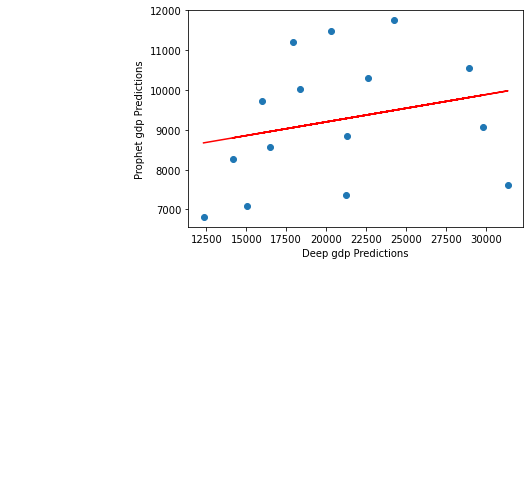